In [19]:
import mesa
import mesa_geo as mg
import geopandas as gpd
from shapely.geometry import Point
import random

In [20]:
# GeoSpace to hold GIS-based agents
class TrafficGeoSpace(mg.GeoSpace):
    def __init__(self):
        super().__init__(crs="EPSG:3857")  # Set CRS explicitly

# Vehicle Agent
class VehicleAgent(mg.GeoAgent):
    def __init__(self, unique_id, model, geometry, crs="EPSG:3857"):
        super().__init__(unique_id, model, geometry, crs)
        self.speed = random.uniform(10, 20)  # Speed in arbitrary units

    def step(self):
        # Example behavior: move randomly
        new_position = self.random_move()
        self.geometry = new_position

    def random_move(self):
        x, y = self.geometry.xy
        x_new = x[0] + random.uniform(-0.001, 0.001)
        y_new = y[0] + random.uniform(-0.001, 0.001)
        return Point(x_new, y_new)


In [21]:
# Traffic Model
class TrafficModel(mesa.Model):
    def __init__(self, road_network_file):
        super().__init__()  # Explicitly initialize the Model
        self.schedule = mesa.time.RandomActivation(self)
        self.space = TrafficGeoSpace()
        self.load_roads(road_network_file)
        self.create_vehicles(50)  # Number of vehicles
        self.vehicle_positions = []  # Store vehicle positions

    def load_roads(self, road_network_file):
        roads = gpd.read_file(road_network_file)
        for idx, road in roads.iterrows():
            road_agent = mg.GeoAgent(idx, self, road.geometry, roads.crs)
            self.space.add_agents(road_agent)

    def create_vehicles(self, num_vehicles):
        for i in range(num_vehicles):
            x, y = random.uniform(-10, 10), random.uniform(-10, 10)  # Random start positions
            vehicle = VehicleAgent(i, self, Point(x, y))
            self.space.add_agents(vehicle)
            self.schedule.add(vehicle)

    def step(self):
        self.schedule.step()
        self.collect_data()  # Collect data after each step

    def collect_data(self):
        positions = [(agent.unique_id, agent.geometry.x, agent.geometry.y) for agent in self.schedule.agents if isinstance(agent, VehicleAgent)]
        self.vehicle_positions.append(positions)

# Running the Model
road_network_file = "roads.shp"  # Update this path
model = TrafficModel(road_network_file)

In [22]:
for i in range(100):  # Run for 100 steps
    model.step()

In [23]:
import folium

# Create a map centered around the initial positions of the vehicles
map_center = [0, 0]  # Change this to your actual center coordinates if needed
mymap = folium.Map(location=map_center, zoom_start=12)

# Add vehicle positions to the map
for step in model.vehicle_positions:
    for unique_id, x, y in step:
        folium.Marker(location=[y, x], popup=f'Vehicle {unique_id}').add_to(mymap)

# Save the map to an HTML file
mymap.save("vehicle_positions_map.html")


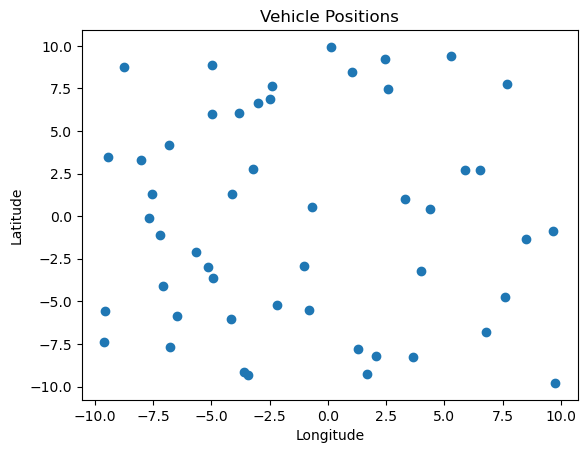

In [24]:
import matplotlib.pyplot as plt

def plot_vehicles(model):
    x = [agent.geometry.x for agent in model.space.agents if isinstance(agent, VehicleAgent)]
    y = [agent.geometry.y for agent in model.space.agents if isinstance(agent, VehicleAgent)]
    plt.scatter(x, y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vehicle Positions')
    plt.show()

plot_vehicles(model)
